# Systematic Scan Gibbs Sampling Algorithm

The Systematic Scan Gibbs Sampling Algorithm updates each dimension in the order in which they appear in the representation of the state, at each update using the current values of the other dimensions of the state like this:

### $$ 1. X_{1}^{(t)} \sim \pi_{X_{j}|X_{-j}}(\cdot|X_{2}^{(t)}, \dots  X_{d}^{(t-1)}) \\ ...\\ j. X_{j}^{(t)} \sim \pi_{X_{j}|X_{-j}}(\cdot|X_{1}^{(t)}, \dots , X_{j-1}^{(t)}, X_{j+1}^{(t-1)},\dots X_{d}^{(t-1)}) \\ ...\\ d. X_{d}^{(t)} \sim \pi_{X_{d}|X_{-j}}(\cdot|X_{1}^{(t)}, \dots X_{d-1}^{(t-1)}) $$

In this notebook we will show some of implementations (good and bad examles) of the Systematic Scan Gibbs Sampling algorithm 

In [1]:
# Import required libraries
import seqgibbs

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

## A good example

Let $X := (X_1,X_2) \sim N(\mu, \Sigma)$ where $\mu = (\mu_1, \mu_2)$ and covariance matrix 
$
\Sigma = \begin{pmatrix}
\sigma^2_1 & \rho \\
\rho & \sigma^2_2
\end{pmatrix}
$
.



The Gibbs sampler proceeds as follows in this case with the following conditional probabilities:

(a) Sample $X_1^{(t)} \sim N (\mu_1 +\rho/\sigma_2^2(X_2^{(t−1)}−\mu_2), \sigma_1^2−\rho^2/\sigma_2^2)$

(b) Sample $X_2^{(t)} \sim N (\mu_2 +\rho/\sigma_1^2(X_1^{(t)}−\mu_1), \sigma_2^2−\rho^2/\sigma_1^2)$.

Firstly, we take the case when the dimesnions of the target distribution are highly correlated, i.e. $\rho = 0.99$.

In [16]:
# Set correlation coefficient
rho = 0.99

# Set other parameters of the target distribution
mu1, mu2, var1, var2 = (5, 5 , 2, 1)

# Create now functions that return the parameters for the unidimensional simulator
# for X1 and X2 in terms of the current position.
# The sampler has a normal distribution shape so these parameters need
# to be the mean and variance of the dsitribution.
def first_fun(x):
    return mu1 + rho/var2 *(x - mu2), var1 - rho**2/var2

def second_fun(x):
    return mu2 + rho/var1 *(x - mu1), var2 - rho**2/var1

# Now create the unidimensional samplers for each of the two dimensions X1 and X2
first_sampler = seqgibbs.OneDimSampler(scipy.stats.norm.rvs, first_fun)
second_sampler = seqgibbs.OneDimSampler(scipy.stats.norm.rvs, second_fun)

# Now create wrapper Systematic Scan Gibbs sampler starting at the default position (origin)
# to which we then feed the two unidimensional samplers we constructed.
sys_sampler = seqgibbs.SysGibbsAlgo(num_dim=2, initial_state=np.array([0, 0]))

sys_sampler.add_1_d_sampler(first_sampler)
sys_sampler.add_1_d_sampler(second_sampler)

# Run 200 complete scan cycles of the algorithm and save the chain
chain1 = sys_sampler.run(num_cycles=200)

### First we plot the sampled chain against the target distribution mass

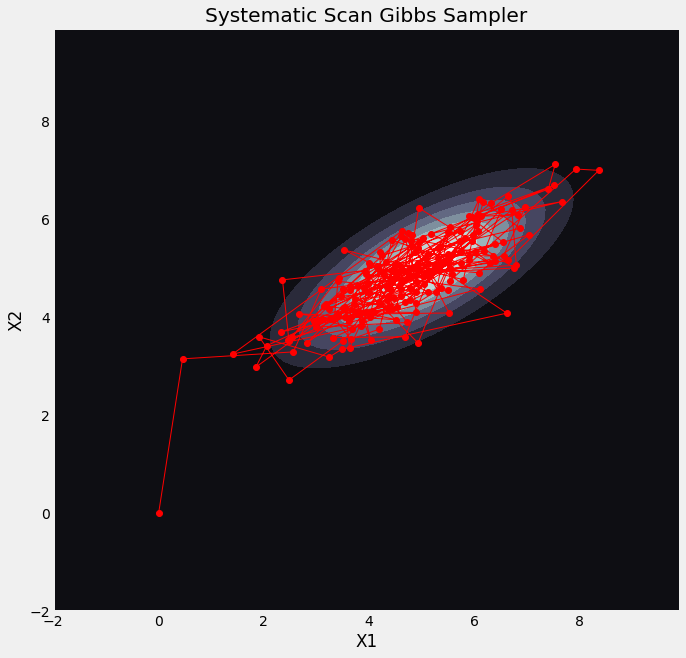

In [22]:
# Plot target distribution in white and grey
from matplotlib import style
style.use('fivethirtyeight')
from scipy.stats import multivariate_normal

x,y = np.mgrid[-2:10:.1, -2:10:0.1]

pos = np.dstack((x, y))
rv = multivariate_normal([mu1, mu2], [[var1, rho], [rho, var2]])
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.contourf(x, y, rv.pdf(pos), cmap=plt.cm.bone)

# Separate the 1st and second dimensions of the states in the chain and
# plot the Gibbs sampler steps
gibbs_x1 = np.asarray(chain1)[:,0].tolist()
gibbs_x2 = np.asarray(chain1)[:,1].tolist()

plt.plot(gibbs_x1, gibbs_x2, marker='o', c='r', linewidth=1)

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Systematic Scan Gibbs Sampler')
plt.show()

### Now we construct a histogram of the each component of the state

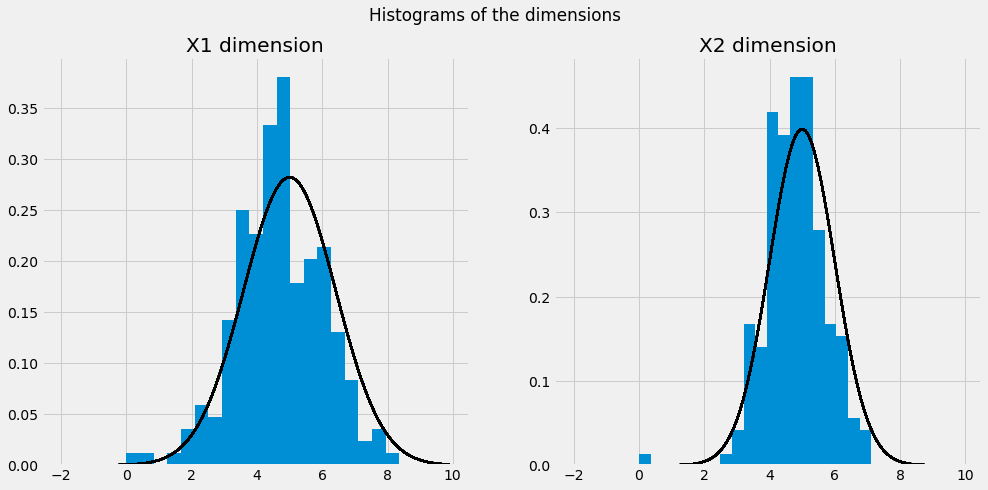

In [23]:
from math import sqrt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Histograms of the dimensions')
ax1.hist(gibbs_x1, 20, density=True)
ax1.plot(x, scipy.stats.norm(mu1, sqrt(var1)).pdf(x), 'k-', lw=2, label='frozen pdf')
ax1.set_title('X1 dimension')
ax2.hist(gibbs_x2, 20, density=True)
ax2.plot(x, scipy.stats.norm(mu2, sqrt(var2)).pdf(x), 'k-', lw=2, label='frozen pdf')
ax2.set_title('X2 dimension')

plt.show()

### Overlay multiple chains

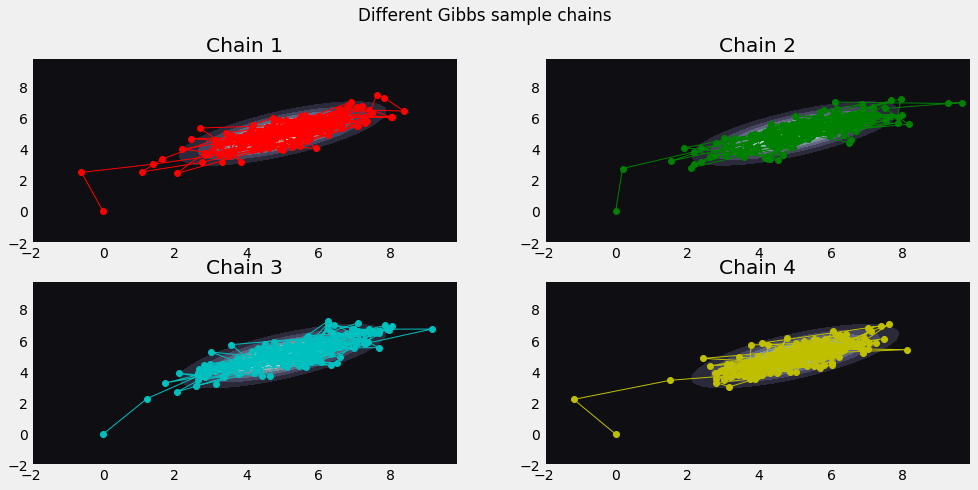

In [24]:
# Plot 4 chains in parallel

fig, (axs) = plt.subplots(2, 2, figsize=(15, 7))
fig.suptitle('Different Gibbs sample chains')

# Run 200 complete scan cycles of the algorithm and save the chain
chain1 = sys_sampler.run(num_cycles=200)
gibbs_x1 = np.asarray(chain1)[:,0].tolist()
gibbs_x2 = np.asarray(chain1)[:,1].tolist()

axs[0, 0].contourf(x, y, rv.pdf(pos), cmap=plt.cm.bone)
axs[0, 0].plot(gibbs_x1, gibbs_x2, marker='o', c='r', linewidth=1)
axs[0, 0].set_title('Chain 1')

# Rerun 200 complete scan cycles of the algorithm and save the chain
chain2 = sys_sampler.run(num_cycles=200)
gibbs_x1 = np.asarray(chain2)[:,0].tolist()
gibbs_x2 = np.asarray(chain2)[:,1].tolist()

axs[0, 1].contourf(x, y, rv.pdf(pos), cmap=plt.cm.bone)
axs[0, 1].plot(gibbs_x1, gibbs_x2, marker='o', c='g', linewidth=1)
axs[0, 1].set_title('Chain 2')

# Rerun 200 complete scan cycles of the algorithm and save the chain
chain3 = sys_sampler.run(num_cycles=200)
gibbs_x1 = np.asarray(chain3)[:,0].tolist()
gibbs_x2 = np.asarray(chain3)[:,1].tolist()

axs[1, 0].contourf(x, y, rv.pdf(pos), cmap=plt.cm.bone)
axs[1, 0].plot(gibbs_x1, gibbs_x2, marker='o', c='c', linewidth=1)
axs[1, 0].set_title('Chain 3')

# Rerun 200 complete scan cycles of the algorithm and save the chain
chain4 = sys_sampler.run(num_cycles=200)
gibbs_x1 = np.asarray(chain4)[:,0].tolist()
gibbs_x2 = np.asarray(chain4)[:,1].tolist()

axs[1, 1].contourf(x, y, rv.pdf(pos), cmap=plt.cm.bone)
axs[1, 1].plot(gibbs_x1, gibbs_x2, marker='o', c='y', linewidth=1)
axs[1, 1].set_title('Chain 4')

plt.show()

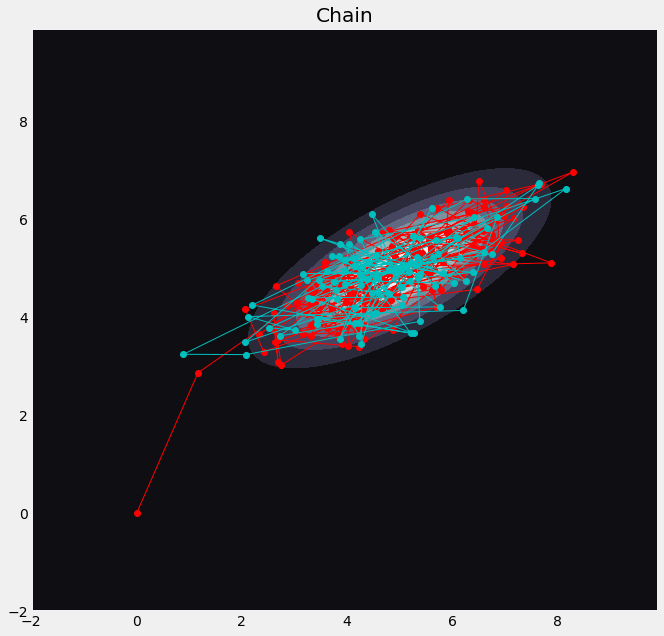

In [25]:
# Can also extend our running of the algortihm by changing the mode in which we run the sampler
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

# Run 200 complete scan cycles of the algorithm and save the chain
chain = np.copy(sys_sampler.run(num_cycles=200)).tolist()
gibbs_x1 = np.asarray(chain)[:,0].tolist()
gibbs_x2 = np.asarray(chain)[:,1].tolist()

ax0.contourf(x, y, rv.pdf(pos), cmap=plt.cm.bone)
plt.plot(gibbs_x1, gibbs_x2, marker='o', c='r', linewidth=1)
ax0.set_title('Chain')

# Run for another 100 complete scan cycles of the algorithm and save the chain
extended_chain = sys_sampler.run(num_cycles=100, mode='continue')[len(chain)-1:]
extended_gibbs_x1 = np.asarray(extended_chain)[:,0].tolist()
extended_gibbs_x2 = np.asarray(extended_chain)[:,1].tolist()

plt.plot(extended_gibbs_x1, extended_gibbs_x2, marker='o', c='c', linewidth=1)

plt.show()

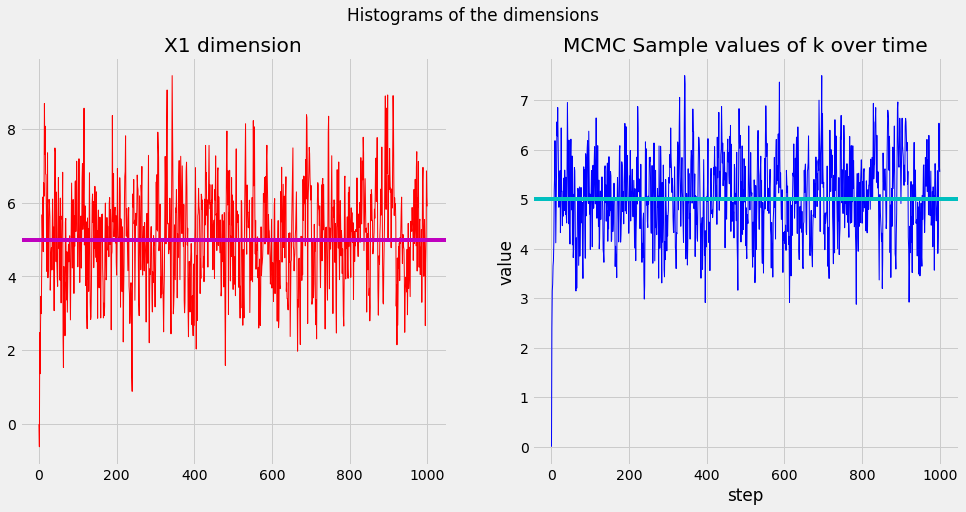

In [26]:
# Run 1000 complete scan cycles of the algorithm and save the chain
chain = np.copy(sys_sampler.run(num_cycles=1000)).tolist()
gibbs_x1 = np.asarray(chain)[:,0].tolist()
gibbs_x2 = np.asarray(chain)[:,1].tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Histograms of the dimensions')
ax1.plot(range(1001), gibbs_x1, c='r', linewidth=1)
ax1.axhline(mu1, c='m')
ax1.set_title('X1 dimension')

plt.plot(range(1001), gibbs_x2, c='b', linewidth=1)
ax2.axhline(mu2, c='c')
ax2.set_title('X2 dimension')

plt.xlabel('step')
plt.ylabel('value')

plt.title('MCMC Sample values of k over time')
plt.show()

Average behaviours of the X1 and X2 dimensions are close to the true means mu1 and mu2. Hence we conclude the sampling is adequate enough.

## Cautionary tale - A bad example

Traget distribution
$\pi(x, y) \propto \mathbb{1}_{[−1.5, 0.5]×[−1.5, 0.5]∪[0.5, 1.5]×[0.5, 1.5]}(x, y)$

Then, the conditional distributions for both dimensions are:

The reason why the algorithm fails to retrieve the correct distribution in this case is because the target distribution violates the positivity condition: